# Week 8: Factor Investing 

---

### Libraries we will be using:

For this week we will be using some of the same packages used in the other finance modules:

- dplyr: This package allows us increased flexibility and simplified syntax for applying data frame operations.

- ggplot2: This package allows us greatly improved plotting functionality in comparison to base R

- tidyquant: This package allows us to scrape stock data from the web using a user friendly api. To use this package, you must not only have it installed and loaded, but you must also have an account and api key with tiingo (but don't worry its free). Their website, how to register, and how to receive your personal api key can be found at https://www.tiingo.com/.

- xts: This package allows us to better manage time series objects in R which is especially important when dealing with financial data.

- PerforamnceAnalytics: This package gives us access to a wide variety of functions directly applicable to financial series data. These functions will greatly reduce the amount of manual coding we will have to do when dealing with common ratios, metrics, and return calculations and conversions.

- Zoo: This package provides some backend support and enhanced functionality when paired with the xts library. 

- Lubridate: This package also adds additional functionality when dealing with time series objects.



In [3]:
library(tidyquant)
library(xts)
library(PerformanceAnalytics)
library(dplyr)
library(ggplot2)
library(zoo)
library(lubridate)
library(xts)
library(stargazer)

### Setting up Tidyquant's API Key:

Now that we have our packages loaded in, there are a couple of things we need to do prior to being able to use the full functionality of Tidyquant. As mentioned above we will need to register your unique API key with the package so that we can successfully query stock data from the web. This process is simple just copy your personal api key you created at https://www.tiingo.com/ and assign it to a variable as a string. Then use the "tiingo_api_key(key)" function to register your key with this R session as the example below illustrates.


In [4]:
personal_tiingo_api_key = '769f1913c5a6b136ab607b83b2900335ba94de21'
tiingo_api_key(personal_tiingo_api_key)

Token has been set for this R session only. It is recommended to instead set the `RIINGO_TOKEN` environment variable in an `.Renviron` file using `usethis::edit_r_environ()`, and then restart R.



Note: There are ways to make your api_key work on all R sessions on your local computer by registering the api_key with the global R environment. We won't cover this process here as it is local machine specific. However, if you wish to learn more about this just check out the tidyquant documentation.

---

### Downloading our Factor Data from the Web:

The first thing we are going to accomplish in this notebook is to fetch the historical factor data directly from the source. Kenneth French one of the two individuals responsible with developing factors models for finance, to this day maintains a current database of the factor data we are looking for at his personal website https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html. If you navigate to the website, you will notice nearly 100 different options factor data models to choose from. As you can see, they maintain historical factor data on several different factor combinations, industries, and countries. Today however we will be sticking to only two datasets "Fama/French North American 5 Factors Daily" which contains all but one of our desired factors. To get the momentum factor we also need to download and format "North American Momentum Factor (Mom) Daily” and merge the two frames along dates to get a unified data frame for use in constructing the factor regression models. 

Below we call a function get_french_factors to download and unzip both datasets. The function first checks to see if the data is already in your current directory if so you're good to go, but if not, it downloads them directly from the web and unzips them into your current working directory, and outputs "TRUE" if the operation was successful. If for any reason this function does not work on your local machine you can always just go to the website itself, download the files, and unzip them yourself, but hopefully this function should take that legwork out of the equation.  


In [5]:
get_french_factors <- function(){
    if (!("North_America_5_Factors_Daily.csv" %in% list.files() && "North_America_MOM_Factor_Daily.csv" %in% list.files())){
        momentum_destination_path = paste(getwd(),"/North_America_Mom_Factor_Daily_CSV.zip",sep="")
        five_factors_destination_path = paste(getwd(),"/North_America_5_Factors_Daily_CSV.zip",sep="")
        momentum_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/North_America_Mom_Factor_Daily_CSV.zip"
        five_factors_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/North_America_5_Factors_Daily_CSV.zip"
        download.file(momentum_url,destfile = momentum_destination_path)
        download.file(five_factors_url,destfile = five_factors_destination_path)
        unzip(paste(getwd(),"/North_America_Mom_Factor_Daily_CSV.zip",sep=""))
        unzip(paste(getwd(),"/North_America_5_Factors_Daily_CSV.zip",sep=""))
        file.remove("North_America_Mom_Factor_Daily_CSV.zip")
        file.remove("North_America_5_Factors_Daily_CSV.zip")
    }
    }

In [6]:
get_french_factors()

### Load and format our factor data files

Now that we have our individual csv files containing the five-factor data and momentum data we can load both into R as data frames. However, a couple of things to note about the way the data is stored:

- These CSV files will both have some un-needed blank lines and information for the first 6 lines of the document so when loading we will need to skip the first 6 rows

- The information in these skipped rows is only there to tell the user where the data was retrieved from and how they indicate unavailable data entries within the dataset. which in this case is with the value -99.99

- Using a value like -99.99 probably is not the best idea from a best practices standpoint as a user could easily miss this tidbit and have catastrophic model problems as a result. However, luckily the data we are dealing with will not have any of these missing entries.

- Each CSV by default will store the date in string format of 'YYYYMMDD' so once our data frame is loaded we will need to use the ymd() function to properly convert our data column into a data datatype as opposed to character type.

- We can also see that both of our date columns are initially labeled as "X" by default, lets also rename that column as well.

Now let’s load and apply these changes to the momentum csv file with the code cell below: 


In [7]:
momentum_frame = read.csv("North_America_MOM_Factor_Daily.csv",skip=6)
momentum_frame = momentum_frame %>% rename(Date=X)
momentum_frame$Date = ymd(momentum_frame$Date)
head(momentum_frame)

Date       WML  
1 1990-11-01 -0.10
2 1990-11-02 -0.58
3 1990-11-05 -0.58
4 1990-11-06 -0.01
5 1990-11-07  0.19
6 1990-11-08  0.09

As we can see from the first few rows everything looks good so far next, we do the same thing for our five-factor dataset.

In [8]:
five_factor_frame = read.csv("North_America_5_Factors_Daily.csv",skip=6)
five_factor_frame = five_factor_frame %>% rename(Date=X)
five_factor_frame$Date = ymd(five_factor_frame$Date)
head(five_factor_frame)

Date       Mkt.RF SMB   HML   RMW   CMA   RF  
1 1990-07-02  0.30  -0.36 -0.12  0.29 -0.04 0.03
2 1990-07-03  0.14  -0.08 -0.40  0.40 -0.23 0.03
3 1990-07-04 -0.01  -0.02  0.02 -0.01  0.01 0.03
4 1990-07-05 -1.00   0.46  0.08 -0.08 -0.01 0.03
5 1990-07-06  0.56  -0.52 -0.34  0.39 -0.03 0.03
6 1990-07-09  0.20  -0.20 -0.05  0.16 -0.33 0.03

### Merge the two factor data frames

Now that we have both data frames loaded properly we can use R's merge() function to perform an inner join of the two frames along the Date feature. The reason we choose an inner join here is because we can see from examining both data frames the momentum data does not go back quite as far as the five-factor data does, so we will need to throw away some of the older observations so that the times periods match exactly.

We can also see that French stores the factor names with different acronyms than the ones used in class. So, we will need to go in and rename these columns according to the names we use in class for consistency. 

    - WML (Winners Minus Losers) = MOM (Momentum)
    - CMA (Conservative Minus Aggressive) = BAB (Betting against Beta often synonymous with Low Volatility)
    - RMW (Robust Minus Weak) = QMJ (Quality minus Junk or Profitability)

Each of these operations is carried out in the code cell below. Also note the commented-out line of code that allows the user to write this new data frame to its own csv file for later use.


In [9]:
merged_frame = merge(five_factor_frame,momentum_frame,by='Date')
merged_frame = merged_frame %>% rename(MOM=WML) %>% rename(BAB=CMA) %>% rename(QMJ=RMW) %>% rename(MKT_RF=Mkt.RF)
merged_frame = merged_frame %>% select(Date,RF,MKT_RF,HML,SMB,QMJ,BAB,MOM) 
#write.table(merged_frame,file="Fama_French_Factors.csv",sep=",",row.names=F)
head(merged_frame)

Date       RF   MKT_RF HML   SMB   QMJ   BAB   MOM  
1 1990-11-01 0.03  0.77   0.00 -0.78  0.17  0.17 -0.10
2 1990-11-02 0.03  1.43  -0.16 -0.61 -0.65 -0.32 -0.58
3 1990-11-05 0.03  0.92  -0.48 -0.26  0.05 -0.95 -0.58
4 1990-11-06 0.03 -0.67   0.46  0.68 -0.29 -0.13 -0.01
5 1990-11-07 0.03 -1.52   0.64  1.04 -0.29  0.30  0.19
6 1990-11-08 0.03  0.36   0.07 -0.76  0.04 -0.09  0.09

---

### Looking at the Correlation of Factors:

As noted in the Fama and French paper, there are some factors that resemble one another quite closely and are often proxies for one another given these relationships. To get a better view of this lets plot a correlation matrix of our factor values using the pairs() function as shown below. What does this correlation plot say about certain pairs of variables? Is it a good think that we have correlation among factor pairs?


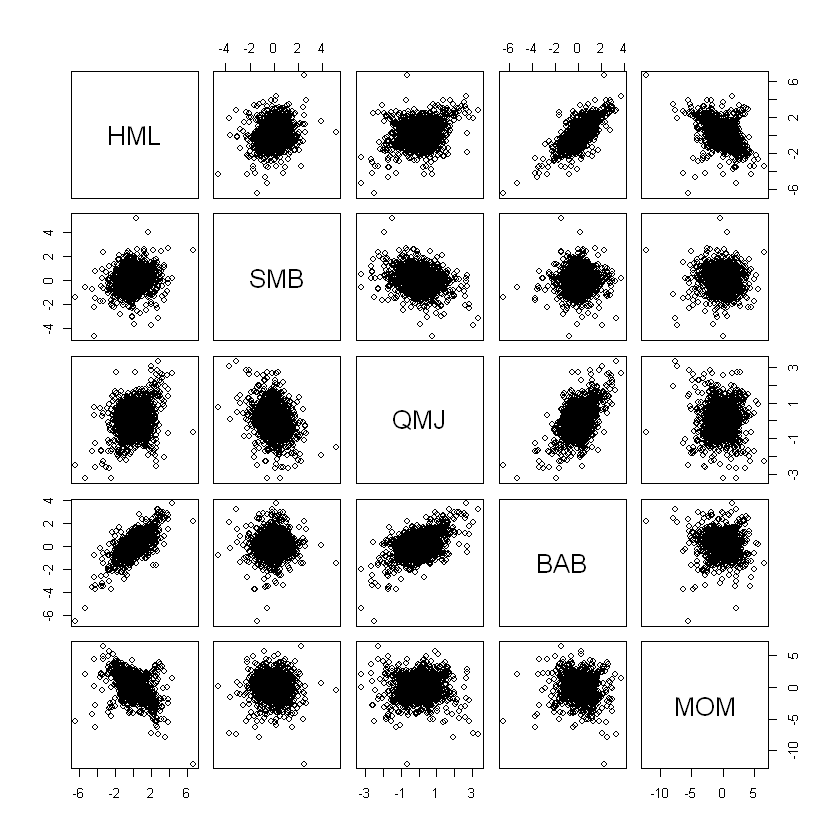

In [10]:
factors_paried = merged_frame %>% select(HML,SMB,QMJ,BAB,MOM)
pairs(factors_paried,labels = colnames(factors_paried),  pch = 21)

Ideally, we would like to see each of our correlation plots above appear trendless, mean-centered, and normal. However, as we can plainly see from pairs such as HML and BAB, QMJ and BAB, MOM and HML there appear to be some collinearity with respect to one another which could prove problematic as we use these factors to fit our factor regression model. Looking at the pairs that are strongly correlated it’s pretty evident that this correlation makes sense. For example, QMJ or profitability is correlated with low-risk stocks. This makes sense as companies that have high profitability ratios are less risk than ones with thinner operating margins. The same goes for HML or mega caps and BAB. Mega cap companies like Microsoft are far less risky than small caps which face a far greater chance of bankruptcy. The correlation seen in MOM and HML is less applicable to a straightforward explanation. One argument for this could be the survivorship bias among larger companies paired with the stock market's general trend towards steady increases or the notion that momentum gains in blue chip stocks drive market performance or is a leading indicator of market rallies. These theories are far less intuitive than the prior to so ponder them with a bit of caution. what is important to take away here is the at times subltle overlapping of these metrics with respect to one another. 

---

### Loading Stock Data:

Now that we have our factor data organized its time to get the last piece of data required prior to building our factor model which is stock data. In the notebook we will use the same Tiingo api used in weeks 6 and 7 so this may look familiar to those of you who have gone through the advanced R code files for those weeks, and for those of you who haven't used this library before these advanced code files do a great job at introducing their functionality so check them out if you want to learn more out them and their use cases.

Below we use the Tiingo api to query the daily prices for Microsoft stock ticker MSFT using a date range of 2017-12-31 to 2021-01-01. This function will output a data frame that includes a lot daily price information such as open, close, midpoint, ... etc., but for the purposes of this notebook we are only concerned with the daily stock returns (using adjusted closing price as our basis) which can be calculated from the other data using tidyquant's tq_transmutate() function. Note we also multiply by 100 to bring our returns into percentage form which is the same format used by our factor data. These operations on the data frame are demonstrated in the code cell below:


In [11]:
MSFT_data = tq_get(x='MSFT',get="stock.price",from='2017-12-31',to='2021-01-01')
MSFT_data = MSFT_data %>% tq_transmute(select=adjusted,mutate_fun=periodReturn,period="daily") %>% rename(Date=date) %>% rename(MSFT=daily.returns) %>% mutate(MSFT=MSFT*100)
head(MSFT_data)

Date       MSFT       
1 2018-01-02  0.00000000
2 2018-01-03  0.46539372
3 2018-01-04  0.88014292
4 2018-01-05  1.23981762
5 2018-01-08  0.10203326
6 2018-01-09 -0.06794413

---

### Merge Factor and Stock Data Frames:

Now that our stock return data has been properly retrieved and formatted it’s time to merge its data frame with our factor data. Again, we use R's merge() function to perform an inner join on the Dates between the data frames which will match up each period's return to its corresponding factor entry. Once our frame is merged, we still have one last data transformation to perform prior to forming our factor model. Since we pulled the returns directly from the stocks prices, we have the stocks total basic daily return in order for the factor model to work properly we need to remove each daily return's respective risk free rate to get daily returns in excess of the risk free rate. This can be done fairly easily with the mutate() function provided by dplyr as shown in the cell below:


In [12]:
joint_frame = merge(merged_frame,MSFT_data,by='Date')
joint_frame = joint_frame %>% mutate(MSFT_RF=MSFT-RF) 
head(joint_frame)

Date       RF MKT_RF HML   SMB   QMJ   BAB   MOM   MSFT        MSFT_RF    
1 2018-01-02 0  0.86   -0.08  0.19 -0.52  0.08 -0.40  0.00000000  0.00000000
2 2018-01-03 0  0.58   -0.26 -0.39 -0.61 -0.10  0.40  0.46539372  0.46539372
3 2018-01-04 0  0.45    0.30 -0.21 -0.06  0.24 -0.16  0.88014292  0.88014292
4 2018-01-05 0  0.62   -0.50 -0.32  0.40 -0.35  0.62  1.23981762  1.23981762
5 2018-01-08 0  0.17    0.00 -0.08 -0.06 -0.03  0.23  0.10203326  0.10203326
6 2018-01-09 0  0.13   -0.46 -0.29 -0.08 -0.03  0.52 -0.06794413 -0.06794413

---

### MSFT Performance vs. Market Performance

Now that we have our data in place and properly formatted, let us see how our stock's performance compares over the same time horizon as the market before we jump into building our factor model. We can then plot the returns using the performance analytics library as we have done in past lessons to get a better visualization of how Microsoft performed relative to the market benchmark.


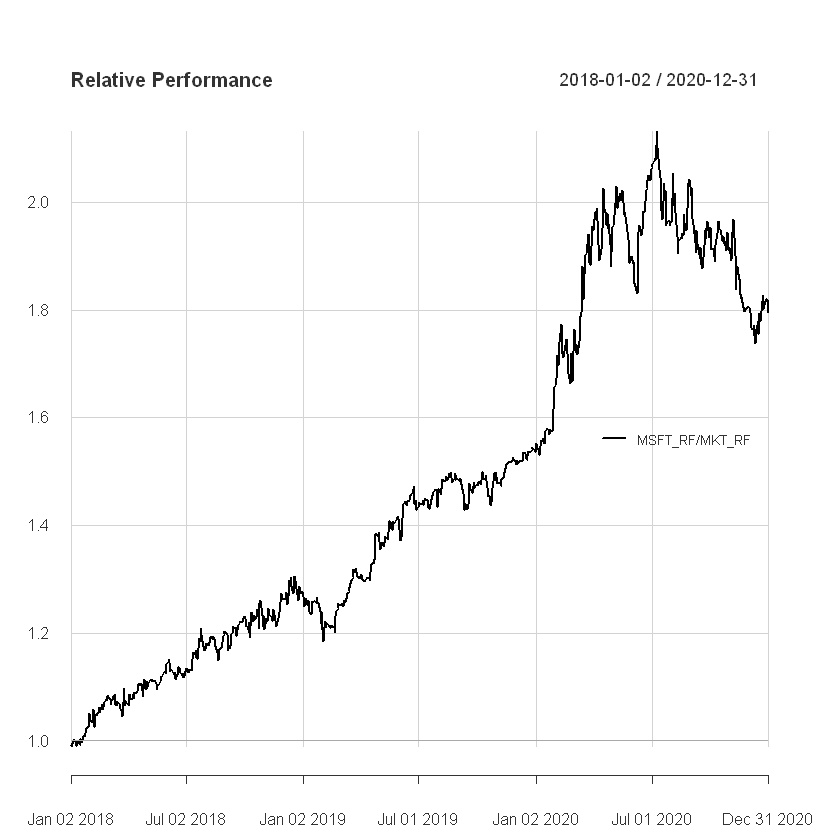

In [13]:
stock_v_market = joint_frame %>% select(Date,MSFT_RF,MKT_RF,RF) %>% mutate(MSFT_RF=(MSFT_RF+RF)/100) %>% mutate(MKT_RF=(RF+MKT_RF)/100) %>% select(Date,MSFT_RF,MKT_RF)
stock_v_market.xts = xts(stock_v_market[,-1],order.by=as.Date(stock_v_market[,1],"%Y%m%d"))
chart.RelativePerformance(stock_v_market.xts[,1, drop=FALSE],stock_v_market.xts[,2, drop=FALSE],geometric = TRUE,legend.loc='right')

As we can see from the relative performance plot above MSFT seems to have outperformed the market quite handily over the sample period. Let's now look to the reasons underlying this performance difference by applying factor models as a means of performance attribution.


---

### Building the Factor Model:

Now that we have our data in place and properly formatted, it is time to build the actual factor model. Using the lm() function we build a linear model where our y variable is the stock returns in excess of the risk free rate and our x variables are the other factor values as well as the MKT_RF variable representing market return in excess of the risk free rate. After fitting our model we use the summary() function to display the output as follows in the code cell below.


In [14]:
MSFT_model = lm(MSFT_RF~MKT_RF+SMB+HML+MOM+BAB+QMJ, data = joint_frame)
summary(MSFT_model)


Call:
lm(formula = MSFT_RF ~ MKT_RF + SMB + HML + MOM + BAB + QMJ, 
    data = joint_frame)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3342 -0.3901 -0.0282  0.3416  4.5439 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.03985    0.02763   1.442  0.14968    
MKT_RF       1.18697    0.01995  59.484  < 2e-16 ***
SMB         -0.46851    0.05273  -8.884  < 2e-16 ***
HML         -0.09658    0.07411  -1.303  0.19293    
MOM          0.14846    0.04659   3.187  0.00150 ** 
BAB         -0.74794    0.10683  -7.001 5.65e-12 ***
QMJ          0.26228    0.08473   3.096  0.00204 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7533 on 749 degrees of freedom
Multiple R-squared:  0.8634,	Adjusted R-squared:  0.8623 
F-statistic: 789.1 on 6 and 749 DF,  p-value: < 2.2e-16


As we can see from the factor model output above, MSFT seems to attribute majority of its performance to betting with beta since BAB is negative, large magnitude, and statistically significant. It seems that over this period MSFT represented a higher-than-average beta stock or higher than average volatility. Additionally, we can see that it also has a large negative, and significant coefficient for SMB meaning MSFT tilts more towards large caps which makes sense as MSFT is one of the largest stocks by market capitalization in the entire world. Microsoft also scores high on the profitability metric QMJ which also makes sense as the company has consistently good margins and profits. We can also see that MSFT has a slightly negative coefficient for HML however, our coefficient is not significant here so we will not consider it. Interestingly, MST finds itself a slight beneficiary of the momentum factor which is likely due to the broad momentum behind large cap tech in general over this sample period. So by breaking down the returns of MSFT and analyzing them both in the context of its fundamentals and history with our factor model we have a powerful tool at better understand the driving forces behind security returns.


---

### How Good are Factor ETF's?

A recent trend on wall street has been the rise of ETF or Exchange traded funds, and among ETFs, factor strategies have been especially popular. Instead of having to use Fama and French's factors to develop your own stock portfolio to take advantage of one of these factors’ companies like Vanguard will instead do the work for you and allow you to directly invest in a large array of value companies for example via their ETF that comes with a relatively small management fee. Sounds like a great deal, right? Maybe not always. In addition to fund management fees buyers also need to consider what is really in that ETF, and it may not always be what you think. So, let's put these ETFs to the test by collecting their daily returns and running a factor analysis to see if they really track the factors, you're paying them for. First, we gather all the ticker data as before and merge it into one collective data frame. Note the tickers we pull here are as follows:

- VV: Vanguard Large-Cap Equity ETF
- VUG: Vanguard Growth ETF
- VFQY: Vanguard Quality ETF
- VFMV: Vanguard Low Volatility ETF
- VFMO: Vanguard Momentum Tracking ETF
- VTV: Vanguard Value ETF

We chose to use all Vanguard funds to remain consistent, and they are one of the largest providers of Exchange traded products, so they had an ETF for each factor. In the code cell below we import the return data for each of these ETFs and return them as a data frame just as we did with the MSFT data.


In [15]:
#Get Large Cap ETF Data
LCAP_ETF_data = tq_get(x='VV',get="stock.price",from='2017-12-31',to='2021-01-01')
LCAP_ETF_data = LCAP_ETF_data %>% tq_transmute(select=adjusted,mutate_fun=periodReturn,period="daily") %>% rename(Date=date) %>% rename(VV=daily.returns) %>% mutate(VV=VV*100)

#Get Growth ETF Data
Growth_ETF_data = tq_get(x='VUG',get="stock.price",from='2017-12-31',to='2021-01-01')
Growth_ETF_data = Growth_ETF_data %>% tq_transmute(select=adjusted,mutate_fun=periodReturn,period="daily") %>% rename(Date=date) %>% rename(VUG=daily.returns) %>% mutate(VUG=VUG*100)

#Get Quality Factor ETF Data
QMJ_ETF_data = tq_get(x='VFQY',get="stock.price",from='2017-12-31',to='2021-01-01')
QMJ_ETF_data = QMJ_ETF_data %>% tq_transmute(select=adjusted,mutate_fun=periodReturn,period="daily") %>% rename(Date=date) %>% rename(VFQY=daily.returns) %>% mutate(VFQY=VFQY*100)

#Get Low Vol Factor ETF Data
LVOL_ETF_data = tq_get(x='VFMV',get="stock.price",from='2017-12-31',to='2021-01-01')
LVOL_ETF_data = LVOL_ETF_data %>% tq_transmute(select=adjusted,mutate_fun=periodReturn,period="daily") %>% rename(Date=date) %>% rename(VFMV=daily.returns) %>% mutate(VFMV=VFMV*100)

#Get Momentum Factor ETF Data
MOM_ETF_data = tq_get(x='VFMO',get="stock.price",from='2017-12-31',to='2021-01-01')
MOM_ETF_data = MOM_ETF_data %>% tq_transmute(select=adjusted,mutate_fun=periodReturn,period="daily") %>% rename(Date=date) %>% rename(VFMO=daily.returns) %>% mutate(VFMO=VFMO*100)

#Get Value Factor ETF Data
Value_ETF_data = tq_get(x='VTV',get="stock.price",from='2017-12-31',to='2021-01-01')
Value_ETF_data = Value_ETF_data %>% tq_transmute(select=adjusted,mutate_fun=periodReturn,period="daily") %>% rename(Date=date) %>% rename(VTV=daily.returns) %>% mutate(VTV=VTV*100)

#Merge all of the collected returns into one dataframe
etf_data = merge(Value_ETF_data,MOM_ETF_data,by='Date')
etf_data = merge(etf_data,LCAP_ETF_data,by='Date')
etf_data = merge(etf_data,LVOL_ETF_data,by='Date')
etf_data = merge(etf_data,Growth_ETF_data,by='Date')
etf_data = merge(etf_data,QMJ_ETF_data,by='Date')

#print the head of the resulting frame
head(etf_data)

Date       VTV         VFMO       VV          VFMV        VUG       
1 2018-02-16  0.12099293  0.0000000  0.05575504  0.39237620 -0.0820428
2 2018-02-20 -0.89252583 -0.7219383 -0.63693018 -0.79468701 -0.3762960
3 2018-02-21 -0.63789153  0.3765956 -0.51281807 -0.07880909 -0.3571094
4 2018-02-22  0.07552297 -0.2716924  0.08053836  0.34169632  0.1102843
5 2018-02-23  1.52831808  0.9210406  1.62562805  0.30126729  1.6867208
6 2018-02-26  1.22651603  1.3110252  1.14824608  1.05770807  1.0697522
  VFQY      
1  1.2133086
2 -0.7759632
3  0.7040749
4 -0.7868639
5  1.0024656
6  0.9577697

Now that our data is properly collected, we merge it with the factor data frame (same as before) using the data range provided by our ETF data frame. We then construct ETF less risk free rate returns for each of the products using mutate().

In [16]:
joint_etf_frame = merge(merged_frame,etf_data,by='Date') %>% mutate(VTV_RF=VTV-RF) %>% mutate(VFMO_RF=VFMO-RF) %>% mutate(VV_RF=VV-RF) %>% mutate(VFMV_RF=VFMV-RF)  %>% mutate(VUG_RF=VUG-RF) %>% mutate(VFQY_RF=VFQY-RF)
head(joint_etf_frame)

Date       RF   MKT_RF HML   SMB   QMJ   BAB   MOM   VTV         VFMO      
1 2018-02-16 0.01  0.01   0.05  0.16 -0.06  0.10 -0.33  0.12099293  0.0000000
2 2018-02-20 0.01 -0.64  -0.34 -0.16 -0.21 -0.56  0.51 -0.89252583 -0.7219383
3 2018-02-21 0.01 -0.41   0.06  0.59 -0.04 -0.22  0.51 -0.63789153  0.3765956
4 2018-02-22 0.01 -0.02  -0.29 -0.11  0.43  0.39  0.25  0.07552297 -0.2716924
5 2018-02-23 0.01  1.50  -0.01 -0.31 -0.06 -0.17 -0.10  1.52831808  0.9210406
6 2018-02-26 0.01  1.04  -0.17 -0.48 -0.07 -0.26  0.18  1.22651603  1.3110252
  VV          VFMV        VUG        VFQY       VTV_RF      VFMO_RF   
1  0.05575504  0.39237620 -0.0820428  1.2133086  0.11099293 -0.0100000
2 -0.63693018 -0.79468701 -0.3762960 -0.7759632 -0.90252583 -0.7319383
3 -0.51281807 -0.07880909 -0.3571094  0.7040749 -0.64789153  0.3665956
4  0.08053836  0.34169632  0.1102843 -0.7868639  0.06552297 -0.2816924
5  1.62562805  0.30126729  1.6867208  1.0024656  1.51831808  0.9110406
6  1.14824608  1.05770807  1.0697522  0.9577697  1.21651603  1.3010252
  VV_RF       VFMV_RF     VUG_RF     VFQY_RF   
1  0.04575504  0.38237620 -0.0920428  1.2033086
2 -0.64693018 -0.80468701 -0.3862960 -0.7859632
3 -0.52281807 -0.08880909 -0.3671094  0.6940749
4  0.07053836  0.33169632  0.1002843 -0.7968639
5  1.61562805  0.29126729  1.6767208  0.9924656
6  1.13824608  1.04770807  1.0597522  0.9477697

Now that we have each of our ETF returns in the proper format and merged with the original factor data frame, we move on to building a factor regression model for each of the ETF. This will allow us to compare the advertised strategy with where our factor model attributes the ETF's return. We begin with Value below:

In [17]:
Value_model = lm(VTV_RF~MKT_RF+SMB+HML+MOM+BAB+QMJ, data = joint_etf_frame)
summary(Value_model)


Call:
lm(formula = VTV_RF ~ MKT_RF + SMB + HML + MOM + BAB + QMJ, data = joint_etf_frame)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.47389 -0.11154  0.00734  0.11739  1.34605 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.007126   0.008289  -0.860     0.39    
MKT_RF       0.975212   0.005996 162.655  < 2e-16 ***
SMB         -0.166329   0.015737 -10.570  < 2e-16 ***
HML          0.146112   0.022056   6.625 6.83e-11 ***
MOM         -0.105531   0.013787  -7.654 6.29e-14 ***
BAB          0.355435   0.031885  11.147  < 2e-16 ***
QMJ         -0.124031   0.025448  -4.874 1.35e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.221 on 717 degrees of freedom
Multiple R-squared:  0.9776,	Adjusted R-squared:  0.9774 
F-statistic:  5206 on 6 and 717 DF,  p-value: < 2.2e-16


As we can see above, our value ETF seems to have a positive and statistically significant coefficient for HML indicating it is likely tilted toward value. However, we can also see that MKT_RF (beta) and BAB are larger in magnitude and significant. It makes sense that these two factors behave similarly here as the portfolio itself has a beta less than one which implies betting slightly against market beta. So, with this in mind, is this ETF really tracking value or is it low beta? Next, we move onto the growth ETF.

In [18]:
Growth_model = lm(VUG_RF~MKT_RF+SMB+HML+MOM+BAB+QMJ, data = joint_etf_frame)
summary(Growth_model)


Call:
lm(formula = VUG_RF ~ MKT_RF + SMB + HML + MOM + BAB + QMJ, data = joint_etf_frame)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.68933 -0.09516 -0.00080  0.08973  0.52698 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.004035   0.005883   0.686  0.49299    
MKT_RF       1.025724   0.004256 241.028  < 2e-16 ***
SMB         -0.125581   0.011170 -11.243  < 2e-16 ***
HML         -0.194422   0.015655 -12.419  < 2e-16 ***
MOM          0.030699   0.009786   3.137  0.00178 ** 
BAB         -0.252955   0.022632 -11.177  < 2e-16 ***
QMJ          0.129721   0.018063   7.182 1.73e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1569 on 717 degrees of freedom
Multiple R-squared:   0.99,	Adjusted R-squared:   0.99 
F-statistic: 1.188e+04 on 6 and 717 DF,  p-value: < 2.2e-16


Interestingly, the growth factor model shows much of the same conclusions as the value model previously discussed. It has a negative coefficient for HML which is significant as we would expect from a growth portfolio, but again other factors like BAB have larger magnitudes and a more significant coefficient. Again, some of this can be explained via the similarity of a negative BAB coefficient (high beta) as growth stocks typically fall within this category. Still, it’s interesting that growth is not our biggest driver of return for the model. Next, we move onto momentum.

In [19]:
MOM_model = lm(VFMO_RF~MKT_RF+SMB+HML+MOM+BAB+QMJ, data = joint_etf_frame)
summary(MOM_model)


Call:
lm(formula = VFMO_RF ~ MKT_RF + SMB + HML + MOM + BAB + QMJ, 
    data = joint_etf_frame)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.11582 -0.15183  0.01219  0.16753  1.45506 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.008278   0.011884  -0.697    0.486    
MKT_RF       1.007466   0.008596 117.199  < 2e-16 ***
SMB          0.594757   0.022562  26.361  < 2e-16 ***
HML         -0.134686   0.031622  -4.259 2.33e-05 ***
MOM          0.379686   0.019768  19.208  < 2e-16 ***
BAB         -0.025816   0.045715  -0.565    0.572    
QMJ         -0.197238   0.036486  -5.406 8.79e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3169 on 717 degrees of freedom
Multiple R-squared:  0.9631,	Adjusted R-squared:  0.9628 
F-statistic:  3118 on 6 and 717 DF,  p-value: < 2.2e-16


It would make sense that there would be similar coefficients between smaller companies and growth given small companies have more upward potential than mega caps, but the momentum trend is not a natural correlation we would expect to correspond with small caps. It turns out again that a value other than the one we are supposed to be tracking is the most significant performance attribute under the factor model. Also, notable, is given the dates we chose to pull we have sampled from a period in the stock market where growth tech companies have juiced market returns for the past several years and have become momentum names as well growth names. Next, we move onto quality.

In [20]:
QMJ_model = lm(VFQY_RF~MKT_RF+SMB+HML+MOM+BAB+QMJ, data = joint_etf_frame)
summary(QMJ_model)


Call:
lm(formula = VFQY_RF ~ MKT_RF + SMB + HML + MOM + BAB + QMJ, 
    data = joint_etf_frame)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.19117 -0.15816  0.00097  0.13784  2.21493 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0002271  0.0127981  -0.018   0.9858    
MKT_RF       0.9552256  0.0092576 103.183  < 2e-16 ***
SMB          0.5161950  0.0242985  21.244  < 2e-16 ***
HML          0.0335393  0.0340558   0.985   0.3250    
MOM         -0.0565286  0.0212887  -2.655   0.0081 ** 
BAB          0.0176407  0.0492325   0.358   0.7202    
QMJ          0.1922955  0.0392939   4.894 1.22e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3413 on 717 degrees of freedom
Multiple R-squared:  0.9538,	Adjusted R-squared:  0.9534 
F-statistic:  2465 on 6 and 717 DF,  p-value: < 2.2e-16


Again, our factor model clearly shows that SMB makes a larger contribution to the portfolio's performance than the QMJ factor. This portfolio according to our model resembles a portfolio of small caps rather than a portfolio built on highly profitable firms. This distinction is quite interesting as most small firms have yet to become profitable and are still growing typically in a quality factor-based portfolio you would see more mid and large caps that have expanded margins with scale. Next, we move onto a large cap ETF.

In [21]:
Lcap_model = lm(VV_RF~MKT_RF+SMB+HML+MOM+BAB+QMJ, data = joint_etf_frame)
summary(Lcap_model)


Call:
lm(formula = VV_RF ~ MKT_RF + SMB + HML + MOM + BAB + QMJ, data = joint_etf_frame)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.73257 -0.03867 -0.00148  0.04027  1.07793 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.001148   0.003464  -0.331  0.74047    
MKT_RF       1.006180   0.002506 401.552  < 2e-16 ***
SMB         -0.146898   0.006577 -22.336  < 2e-16 ***
HML         -0.016122   0.009218  -1.749  0.08071 .  
MOM         -0.014236   0.005762  -2.471  0.01372 *  
BAB          0.037301   0.013326   2.799  0.00526 ** 
QMJ         -0.007976   0.010636  -0.750  0.45355    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.09238 on 717 degrees of freedom
Multiple R-squared:  0.9961,	Adjusted R-squared:  0.9961 
F-statistic: 3.054e+04 on 6 and 717 DF,  p-value: < 2.2e-16


Finally, after 5 different factor ETFs we have one that resembles what our model would generally expect. The largest and most significant coefficient is the negative SMB coefficient which indicates that we are indeed tilted toward large caps. Lastly, we test the low beta portfolio against the BAB factor.

In [22]:
Lvol_model = lm(VFMV_RF~MKT_RF+SMB+HML+MOM+BAB+QMJ, data = joint_etf_frame)
summary(Lvol_model)


Call:
lm(formula = VFMV_RF ~ MKT_RF + SMB + HML + MOM + BAB + QMJ, 
    data = joint_etf_frame)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1142 -0.1903  0.0215  0.2110  3.9611 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.003669   0.015279  -0.240    0.810    
MKT_RF       0.712121   0.011052  64.432  < 2e-16 ***
SMB          0.204914   0.029009   7.064 3.84e-12 ***
HML          0.007555   0.040657   0.186    0.853    
MOM          0.173303   0.025415   6.819 1.95e-11 ***
BAB          0.363904   0.058776   6.191 1.00e-09 ***
QMJ         -0.002082   0.046911  -0.044    0.965    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4075 on 717 degrees of freedom
Multiple R-squared:  0.8722,	Adjusted R-squared:  0.8712 
F-statistic: 815.8 on 6 and 717 DF,  p-value: < 2.2e-16


Like the large cap portfolio before it, the low volatility ETF lives up to its name given the large positive magnitude of the BAB coefficient which is also very statistically significant. So, out of the six ETF's only two truly lived up to our factor model's expectation for that given strategy. Analysis like this should not be taken as definitive as there are many well managed ETF's out there and factor models with simple regression are not by any means the absolute answer, but I believe it shows the value of informed investing. 

---


### Impact of Factors Over Time:

The effectiveness of style factors can vary greatly over different periods of time, and although each of the factors presented by Fama and French have had some "staying power" over market history, each has seen their high and low points when it comes to being a profitable strategy. In order to examine this further let us look at some of the performance history of each of the factor by using a simple moving average of the factor values to smooth out some of the daily noise. The SMA will also tell us the average value of that given factor over the rolling window which will help us better understand strong and weak periods for each side of the factors two strategies. Below we use the same factor data frame from above and convert it to a time series. Also note that for these visualizations, we are interested in how long and consistently a given factor remains different from zero. If factors had no predictive value, we should only see oscillation around zero.


First, we revist our inital factor frame from earlier.

In [23]:
factor_frame = merged_frame %>% select(Date,HML,SMB,QMJ,BAB,MOM)
factor_frame.xts = xts(factor_frame[,-1],order.by=as.Date(factor_frame[,1],"%Y%m%d"))
head(factor_frame.xts)

             HML   SMB   QMJ   BAB   MOM
1990-11-01  0.00 -0.78  0.17  0.17 -0.10
1990-11-02 -0.16 -0.61 -0.65 -0.32 -0.58
1990-11-05 -0.48 -0.26  0.05 -0.95 -0.58
1990-11-06  0.46  0.68 -0.29 -0.13 -0.01
1990-11-07  0.64  1.04 -0.29  0.30  0.19
1990-11-08  0.07 -0.76  0.04 -0.09  0.09

After formatting it as a proper xts object we use ggplot2 to calculate and plot our various moving averages for each factor. To calculate this moving average we utilize ggplot's built in support for geometric series moving averages via the geom_ma() function as shown below. We continue this process of charting for each of the factors in our data frame.

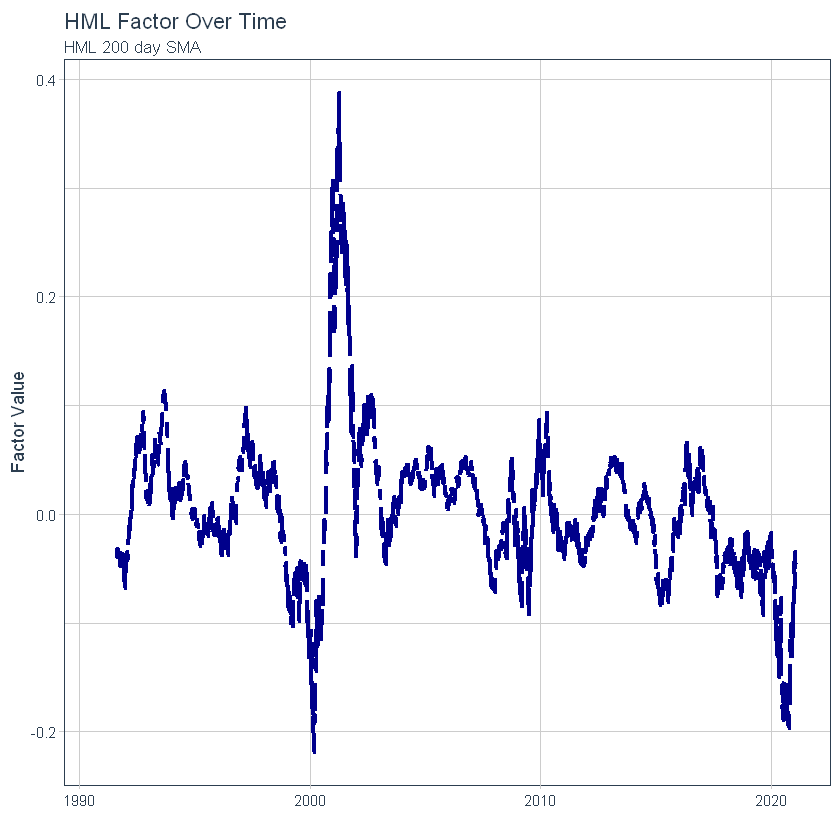

In [24]:
factor_frame %>% ggplot(aes(x=Date, y =HML)) + geom_ma(ma_fun = SMA, n = 200, linetype = 5, size = 1.25) + labs(title = "HML Factor Over Time", subtitle = "HML 200 day SMA", y = "Factor Value", x = "") + theme_tq()

We see a consistently positive HML factor between the mid 90’s to the leadup to the dotcom bubble where growth stole the show. HML returned to favor directly after and during the dotcom bubble as value investors like Buffet lead the new era of value invested decrying the growth craze of the dotcom bubble. We can also see that HML has been somewhat negative as of late which is consistent with what is going on in markets currently growth trades at a significant premium. 

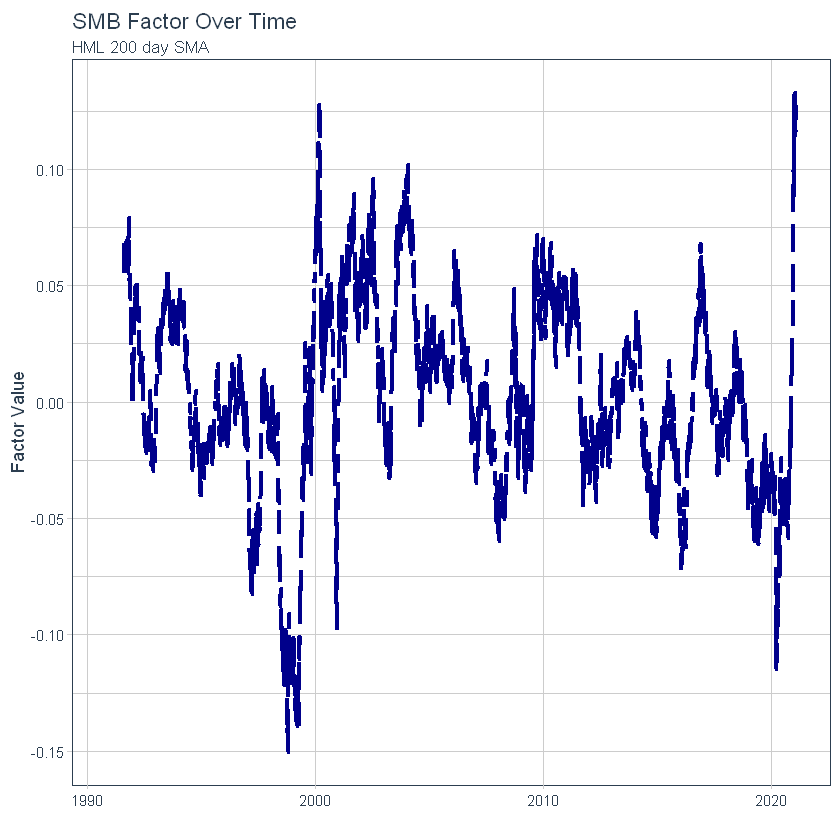

In [25]:
factor_frame %>% ggplot(aes(x=Date, y =SMB)) + geom_ma(ma_fun = SMA, n = 200, linetype = 5, size = 1.25) + labs(title = "SMB Factor Over Time", subtitle = "HML 200 day SMA", y = "Factor Value", x = "") + theme_tq()

For SMB, the trends are much less obvious our of all the factors this plot seems to indicate the smallest magnitude differences from the zero axis. This constant oscillation around zero indicates that this factor may not be as reliable or consistent as some of the others we observe.

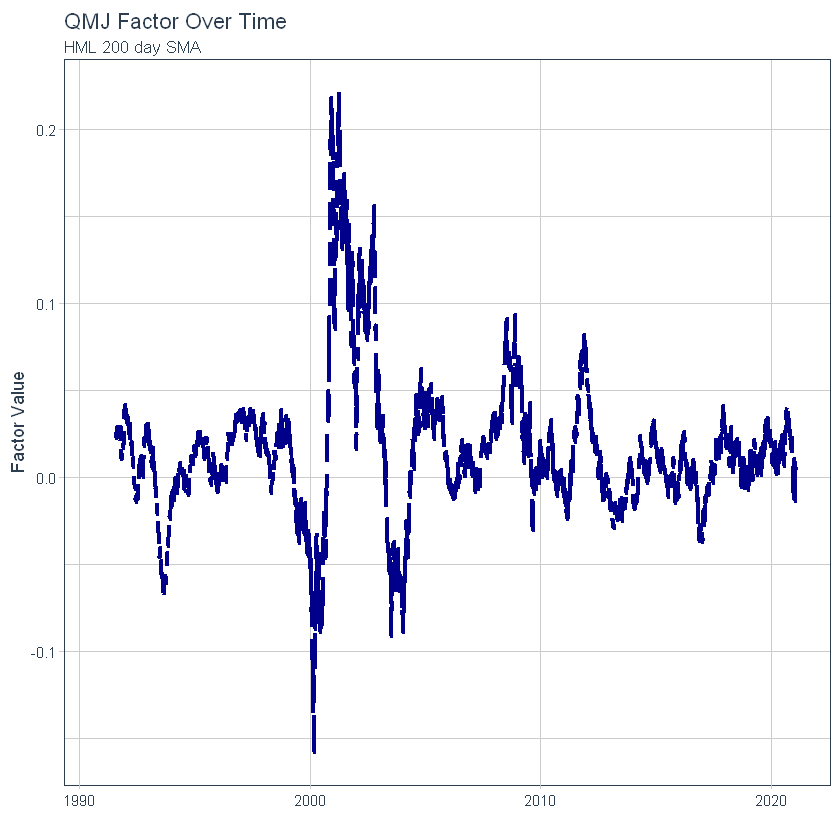

In [26]:
factor_frame %>% ggplot(aes(x=Date, y =QMJ)) + geom_ma(ma_fun = SMA, n = 200, linetype = 5, size = 1.25) + labs(title = "QMJ Factor Over Time", subtitle = "HML 200 day SMA", y = "Factor Value", x = "") + theme_tq()

The QMJ factor chart seems to strongly resemble that of the HML factor. We can see that a positive skew to QMJ seems constant throughout the period with again sharp moves around the 2000's dotcom bubble. This is expected given our analysis of the HML factor in the historical context of the dotcom crash as growth companies with little current profits (but high expectations looking forward) played a dominant role in the collapse of the market during this time which was subsequently followed by an investor craze towards profitable and value stocks as a panacea for the mistakes made in growth.

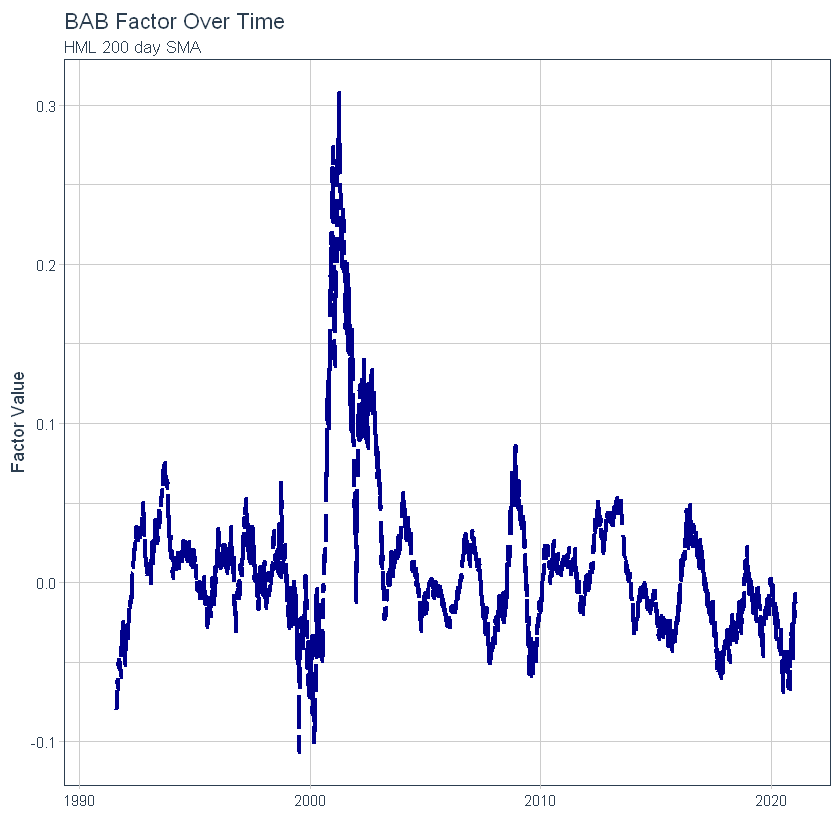

In [27]:
factor_frame %>% ggplot(aes(x=Date, y =BAB)) + geom_ma(ma_fun = SMA, n = 200, linetype = 5, size = 1.25) + labs(title = "BAB Factor Over Time", subtitle = "HML 200 day SMA", y = "Factor Value", x = "") + theme_tq()

The BAB factor seems unique in that it remains fairly constant oscillating around zero not indicating much predicting power in the positive or negative direction just look like a noisy plot. However, BAB shines during recessions when investors flee to market safe havens which is where and when BAB gains its performance. These large spikes skew average performance of BAB over the horizon making it an important factor. It is because of this trait that academics have noted that less risky companies tend to trade higher than they should many call this the insurance or safety premium. This refers to the extra cost to hold safe assets created by excess market demand for low volatility securities.

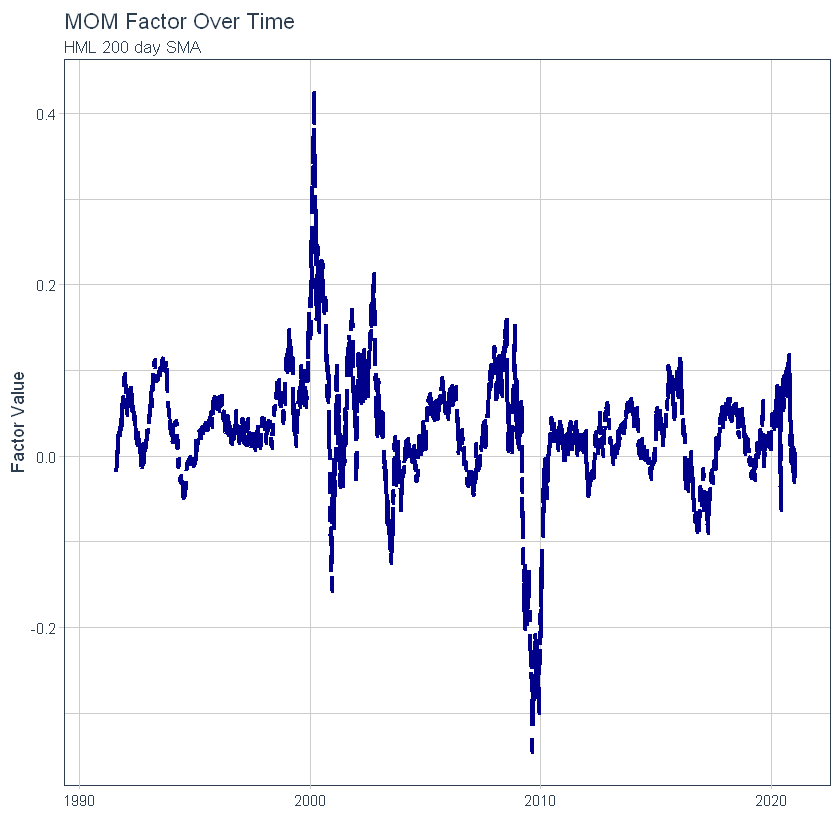

In [28]:
factor_frame %>% ggplot(aes(x=Date, y =MOM)) + geom_ma(ma_fun = SMA, n = 200, linetype = 5, size = 1.25) + labs(title = "MOM Factor Over Time", subtitle = "HML 200 day SMA", y = "Factor Value", x = "") + theme_tq()

Finally, we move onto momentum which as we expect seems to have a pretty strong tendency towards positive observation most of the time. Again, through we see some strong divergence in the dotcom crisis and more specifically the housing crisis of 2008.

The charts above should give you a sense of how erratic these factors behave even under 200 day smoothing. Also notable is the steep peaks in each chart that correspond generally to the same time across all factors this happens in the early 2000's right around the infamous Dotcom bubble. In times of market turbulence such as this as well as 2008 all strategies tend to decouple quickly from their past performance and actually begin to move with one another. We can clearly see that many of these strategies tend (depending on which side you take) to have a persistence over this time period despite some rather long or quick and deep periods of underperformance, the factors generally live up to their proposed behavior. 